In [150]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dm-dataset-2/classesup.npy
/kaggle/input/dm-dataset-2/model_dataset.csv
/kaggle/input/dm-dataset-2/k_fold_10.json
/kaggle/input/dm-dataset-2/classesdown.npy
/kaggle/input/dm-dataset-2/classes.npy
/kaggle/input/linking-writing-processes-to-writing-quality/sample_submission.csv
/kaggle/input/linking-writing-processes-to-writing-quality/test_logs.csv
/kaggle/input/linking-writing-processes-to-writing-quality/train_scores.csv
/kaggle/input/linking-writing-processes-to-writing-quality/train_logs.csv


In [151]:
train=pd.read_csv("/kaggle/input/linking-writing-processes-to-writing-quality/train_logs.csv")
test=pd.read_csv("/kaggle/input/linking-writing-processes-to-writing-quality/test_logs.csv")

In [152]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le2 = LabelEncoder()
le3 = LabelEncoder()
import numpy
le.classes_ = numpy.load('/kaggle/input/dm-dataset-2/classes.npy',allow_pickle=True)
le2.classes_ = numpy.load('/kaggle/input/dm-dataset-2/classes.npy',allow_pickle=True)
le3.classes_ = numpy.load('/kaggle/input/dm-dataset-2/classes.npy',allow_pickle=True)

In [153]:
train['activity_enc']=le.fit_transform(train['activity'])
train['up_enc']=le2.fit_transform(train['up_event'])
train['down_enc']=le3.fit_transform(train['down_event'])
test['activity_enc']=le.fit_transform(test['activity'])
test['up_enc']=le2.fit_transform(test['up_event'])
test['down_enc']=le3.fit_transform(test['down_event'])

In [154]:
pun = ['"', '.', ',', "'", '-', ';', ':', '?', '!', '<', '>', '/',
                        '@', '#', '$', '%', '^', '&', '*', '(', ')', '_', '+']

filtered_data_test = test[test['down_event'].isin(pun)]
result_test = test[test['down_event'].isin(pun)].groupby('id').size().reset_index(name='count')
test

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count,activity_enc,up_enc,down_enc
0,0000aaaa,1,338433,338518,85,Input,Space,Space,,0,0,0,0,0
1,0000aaaa,2,760073,760160,87,Input,Space,Space,,1,0,0,0,0
2,2222bbbb,1,711956,712023,67,Input,q,q,q,0,1,0,1,1
3,2222bbbb,2,290502,290548,46,Input,q,q,q,1,1,0,1,1
4,4444cccc,1,635547,635641,94,Input,Space,Space,,0,0,0,0,0
5,4444cccc,2,184996,185052,56,Input,q,q,q,1,1,0,1,1


In [155]:
pun = ['"', '.', ',', "'", '-', ';', ':', '?', '!', '<', '>', '/',
                        '@', '#', '$', '%', '^', '&', '*', '(', ')', '_', '+']

filtered_data_train = train[train['down_event'].isin(pun)]
result_train = train[train['down_event'].isin(pun)].groupby('id').size().reset_index(name='count')
train

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count,activity_enc,up_enc,down_enc
0,001519c8,1,4526,4557,31,Nonproduction,Leftclick,Leftclick,NoChange,0,0,46,58,60
1,001519c8,2,4558,4962,404,Nonproduction,Leftclick,Leftclick,NoChange,0,0,46,58,60
2,001519c8,3,106571,106571,0,Nonproduction,Shift,Shift,NoChange,0,0,46,75,77
3,001519c8,4,106686,106777,91,Input,q,q,q,1,1,0,104,105
4,001519c8,5,107196,107323,127,Input,q,q,q,2,1,0,104,105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8405893,fff05981,3615,2063944,2064440,496,Nonproduction,Leftclick,Leftclick,NoChange,1031,240,46,58,60
8405894,fff05981,3616,2064497,2064497,0,Nonproduction,Shift,Shift,NoChange,1031,240,46,75,77
8405895,fff05981,3617,2064657,2064765,108,Replace,q,q,q => q,1031,240,49,104,105
8405896,fff05981,3618,2069186,2069259,73,Nonproduction,Leftclick,Leftclick,NoChange,1028,240,46,58,60


In [156]:
#here I will groupy the id and make new features so we can apply meaningful models here
model_train=pd.DataFrame({'id':train['id'].unique()})

# Feature from events
model_train['count_of_events']=train['event_id'].groupby([train['id']]).max().values
# Let's get feature from time
# model_train['mean_down_time']=train['down_time'].groupby([train['id']]).mean().values
# model_train['mean_up_time']=train['up_time'].groupby([train['id']]).mean().values
model_train['mean_action_time']=train['action_time'].groupby([train['id']]).mean().values
# model_train['median_down_time']=train['down_time'].groupby([train['id']]).median().values
# model_train['median_up_time']=train['up_time'].groupby([train['id']]).median().values
model_train['median_action_time']=train['action_time'].groupby([train['id']]).median().values
model_train['sum_action_time']=train['action_time'].groupby([train['id']]).sum().values

# word count
model_train['count_word_count']=train['word_count'].groupby([train['id']]).max().values
model_train['mean_word_count']=train['word_count'].groupby([train['id']]).mean().values
model_train['median_word_count']=train['word_count'].groupby([train['id']]).median().values
model_train['sum_word_count']=train['word_count'].groupby([train['id']]).sum().values

# mode shows that number of time/events user spent the most - can say blockage word?
model_train['idle_word_count']=train['word_count'].groupby([train['id']]).apply(lambda x: x.value_counts().idxmax() if x.value_counts().max() > 1 else x.iloc[-1]).values

# cursor positon
model_train['count_cursor_position']=train['cursor_position'].groupby([train['id']]).max().values
model_train['mean_cursor_position']=train['cursor_position'].groupby([train['id']]).mean().values
model_train['sum_cursor_position']=train['cursor_position'].groupby([train['id']]).sum().values
# median shows the idle time ?
model_train['median_cursor_position']=train['cursor_position'].groupby([train['id']]).median().values
# The mode can tell the idle time of cursor
model_train['idle_cursor_position']=train['cursor_position'].groupby([train['id']]).apply(lambda x: x.value_counts().idxmax() if x.value_counts().max() > 1 else x.iloc[-1] ).values

# Let's do the features now, we will basically do one encode or count the features basically

# model_train['common_activity']=train['activity_enc'].groupby([train['id']]).agg(pd.Series.mode).values
# model_train['common_up_event']=train['up_enc'].groupby([train['id']]).agg(pd.Series.mode).values
# model_train['common_down_event']=train['down_enc'].groupby([train['id']]).apply(lambda x: x.value_counts().idxmax()).values

# activity mapping 
model_train['count_input']=train['activity'].groupby([train['id']]).apply(lambda x: (x == 'Input').sum()).values
model_train['count_remove']=train['activity'].groupby([train['id']]).apply(lambda x: (x == 'Remove/Cut').sum()).values
model_train['count_nonproduction']=train['activity'].groupby([train['id']]).apply(lambda x: (x == 'Nonproduction').sum()).values
model_train['count_replace']=train['activity'].groupby([train['id']]).apply(lambda x: (x == 'Replace').sum()).values
model_train['count_paste']=train['activity'].groupby([train['id']]).apply(lambda x: (x == 'Paste').sum()).values
model_train['input_back_ratio']=model_train['count_input']/model_train['count_remove']

#we will check his vocab
model_train['cursor_word_ratio']=model_train['count_cursor_position']/model_train['count_word_count']

#puncations 
pun = ['"', '.', ',', "'", '-', ';', ':', '?', '!', '<', '>', '/',
                        '@', '#', '$', '%', '^', '&', '*', '(', ')', '_', '+']

filtered_data = train[train['down_event'].isin(pun)]
result = train[train['down_event'].isin(pun)].groupby('id').size().reset_index(name='count')
model_train['count_pun']=result['count']


for ele in train['down_event'].value_counts().index[:10]:
    model_train['count_down_'+ele]=train['down_event'].groupby([train['id']]).apply(lambda x: (x == ele).sum()).values
    
    
for ele in train['up_event'].value_counts().index[:10]:
    model_train['count_up_'+ele]=train['up_event'].groupby([train['id']]).apply(lambda x: (x == ele).sum()).values
    

model_train.shape

(2471, 43)

In [157]:
#here I will groupy the id and make new features so we can apply meaningful models here
model_test=pd.DataFrame({'id':test['id'].unique()})

# Feature from events
model_test['count_of_events']=test['event_id'].groupby([test['id']]).max().values
# Let's get feature from time
# model_test['mean_down_time']=test['down_time'].groupby([test['id']]).mean().values
# model_test['mean_up_time']=test['up_time'].groupby([test['id']]).mean().values
model_test['mean_action_time']=test['action_time'].groupby([test['id']]).mean().values
# model_test['median_down_time']=test['down_time'].groupby([test['id']]).median().values
# model_test['median_up_time']=test['up_time'].groupby([test['id']]).median().values
model_test['median_action_time']=test['action_time'].groupby([test['id']]).median().values
model_test['sum_action_time']=test['action_time'].groupby([test['id']]).sum().values

# word count
model_test['count_word_count']=test['word_count'].groupby([test['id']]).max().values
model_test['mean_word_count']=test['word_count'].groupby([test['id']]).mean().values
model_test['median_word_count']=test['word_count'].groupby([test['id']]).median().values
model_test['sum_word_count']=test['word_count'].groupby([test['id']]).sum().values

# mode shows that number of time/events user spent the most - can say blockage word?
model_test['idle_word_count']=test['word_count'].groupby([test['id']]).apply(lambda x: x.value_counts().idxmax() if x.value_counts().max() > 1 else x.iloc[-1]).values

# cursor positon
model_test['count_cursor_position']=test['cursor_position'].groupby([test['id']]).max().values
model_test['mean_cursor_position']=test['cursor_position'].groupby([test['id']]).mean().values
model_test['sum_cursor_position']=test['cursor_position'].groupby([test['id']]).sum().values
# median shows the idle time ?
model_test['median_cursor_position']=test['cursor_position'].groupby([test['id']]).median().values
# The mode can tell the idle time of cursor
model_test['idle_cursor_position']=test['cursor_position'].groupby([test['id']]).apply(lambda x: x.value_counts().idxmax() if x.value_counts().max() > 1 else x.iloc[-1] ).values

# Let's do the features now, we will basically do one encode or count the features basically

# model_train['common_activity']=train['activity_enc'].groupby([train['id']]).agg(pd.Series.mode).values
# model_train['common_up_event']=train['up_enc'].groupby([train['id']]).agg(pd.Series.mode).values
# model_train['common_down_event']=train['down_enc'].groupby([train['id']]).apply(lambda x: x.value_counts().idxmax()).values

# activity mapping 
model_test['count_input']=test['activity'].groupby([test['id']]).apply(lambda x: (x == 'Input').sum()).values
model_test['count_remove']=test['activity'].groupby([test['id']]).apply(lambda x: (x == 'Remove/Cut').sum()).values
model_test['count_nonproduction']=test['activity'].groupby([test['id']]).apply(lambda x: (x == 'Nonproduction').sum()).values
model_test['count_replace']=test['activity'].groupby([test['id']]).apply(lambda x: (x == 'Replace').sum()).values
model_test['count_paste']=test['activity'].groupby([test['id']]).apply(lambda x: (x == 'Paste').sum()).values
model_test['input_back_ratio']=model_test['count_input']/model_test['count_remove']

#we will check his vocab
model_test['cursor_word_ratio']=model_test['count_cursor_position']/model_train['count_word_count']

#puncations 
pun = ['"', '.', ',', "'", '-', ';', ':', '?', '!', '<', '>', '/',
                        '@', '#', '$', '%', '^', '&', '*', '(', ')', '_', '+']

filtered_data_test = test[test['down_event'].isin(pun)]
result_test = test[test['down_event'].isin(pun)].groupby('id').size().reset_index(name='count')
model_test['count_pun']=result_test['count']


for ele in test['down_event'].value_counts().index[:10]:
    model_test['count_down_'+ele]=test['down_event'].groupby([test['id']]).apply(lambda x: (x == ele).sum()).values
    
    
for ele in test['up_event'].value_counts().index[:10]:
    model_test['count_up_'+ele]=test['up_event'].groupby([test['id']]).apply(lambda x: (x == ele).sum()).values
    

model_test

,id,count_of_events,mean_action_time,median_action_time,sum_action_time,count_word_count,mean_word_count,median_word_count,sum_word_count,idle_word_count,...,count_nonproduction,count_replace,count_paste,input_back_ratio,cursor_word_ratio,count_pun,count_down_Space,count_down_q,count_up_Space,count_up_q
0,0000aaaa,2,86.0,86.0,172,0,0.0,0.0,0,0,...,0,0,0,inf,0.003906,NaN,2,0,2,0
1,2222bbbb,2,56.5,56.5,113,1,1.0,1.0,2,1,...,0,0,0,inf,0.003096,NaN,0,2,0,2
2,4444cccc,2,75.0,75.0,150,1,0.5,0.5,1,1,...,0,0,0,inf,0.002475,NaN,1,1,1,1


In [ ]:
# I noticed some inf value , I did -1 to notice it more
model_train = model_train.replace([np.inf, -np.inf], -1)

In [181]:
scores=pd.read_csv('/kaggle/input/linking-writing-processes-to-writing-quality/train_scores.csv')

rows_with_0_5 = scores[scores['score']==0.5]
rows_with_0_5['id'].values

array(['1ebb9b74', '315bdafd', '3bda31e6', '40b28508', 'c3663a2d'],
      dtype=object)

In [182]:
model_train = model_train[~model_train['id'].isin(rows_with_0_5['id'].tolist())]

In [183]:
model_train.to_csv('/kaggle/working/model_final_final.csv',index=False)

In [184]:
scores=scores[~scores['id'].isin(rows_with_0_5['id'].tolist())]

In [186]:
merged_df = model_train.merge(scores, on='id', how='inner')

In [187]:
merged_df.to_csv('/kaggle/working/model_dataset.csv',index=False)

In [188]:
# now we will make folds 

from sklearn.model_selection import KFold
import json
kf = KFold(n_splits=10, shuffle=True, random_state=42)
merged_df=merged_df.drop(columns=['id'])
fold_indices = []
for train_idx,test_idx in kf.split(merged_df):
    fold_indices.append({
        'train_indices': train_idx.tolist(),
        'test_indices': test_idx.tolist()
    })
    
with open('/kaggle/working/k_fold_10.json', 'w') as file:
    json.dump(fold_indices, file)


In [189]:
merged_df.columns

Index(['count_of_events', 'mean_action_time', 'median_action_time',
       'sum_action_time', 'count_word_count', 'mean_word_count',
       'median_word_count', 'sum_word_count', 'idle_word_count',
       'count_cursor_position', 'mean_cursor_position', 'sum_cursor_position',
       'median_cursor_position', 'idle_cursor_position', 'count_input',
       'count_remove', 'count_nonproduction', 'count_replace', 'count_paste',
       'input_back_ratio', 'cursor_word_ratio', 'count_pun', 'count_down_q',
       'count_down_Space', 'count_down_Backspace', 'count_down_Shift',
       'count_down_ArrowRight', 'count_down_Leftclick', 'count_down_ArrowLeft',
       'count_down_.', 'count_down_,', 'count_down_ArrowDown', 'count_up_q',
       'count_up_Space', 'count_up_Backspace', 'count_up_Shift',
       'count_up_ArrowRight', 'count_up_Leftclick', 'count_up_ArrowLeft',
       'count_up_.', 'count_up_,', 'count_up_ArrowDown', 'score'],
      dtype='object')

In [190]:
model_test.columns

Index(['id', 'count_of_events', 'mean_action_time', 'median_action_time',
       'sum_action_time', 'count_word_count', 'mean_word_count',
       'median_word_count', 'sum_word_count', 'idle_word_count',
       'count_cursor_position', 'mean_cursor_position', 'sum_cursor_position',
       'median_cursor_position', 'idle_cursor_position', 'count_input',
       'count_remove', 'count_nonproduction', 'count_replace', 'count_paste',
       'input_back_ratio', 'cursor_word_ratio', 'count_pun',
       'count_down_Space', 'count_down_q', 'count_up_Space', 'count_up_q',
       'count_down_Shift', 'count_down_ArrowRight', 'count_down_Leftclick',
       'count_down_ArrowLeft', 'count_down_.', 'count_down_,',
       'count_down_ArrowDown', 'count_up_Backspace', 'count_up_Shift',
       'count_up_ArrowRight', 'count_up_Leftclick', 'count_up_ArrowLeft',
       'count_up_.', 'count_up_,', 'count_up_ArrowDown',
       'count_down_Backspace'],
      dtype='object')

In [191]:
model_test[['count_down_Shift',
       'count_down_ArrowRight', 'count_down_Leftclick', 'count_down_ArrowLeft',
       'count_down_.', 'count_down_,', 'count_down_ArrowDown','count_up_Backspace', 'count_up_Shift',
       'count_up_ArrowRight', 'count_up_Leftclick', 'count_up_ArrowLeft',
       'count_up_.', 'count_up_,', 'count_up_ArrowDown']] = 0

In [192]:
columns_to_drop = [
    'count_down_Shift',
    'count_down_ArrowRight',
    'count_down_Leftclick',
    'count_down_ArrowLeft',
    'count_down_.',
    'count_down_,',
    'count_down_ArrowDown',
    'count_up_Backspace',
    'count_up_Shift',
    'count_up_ArrowRight',
    'count_up_Leftclick',
    'count_up_ArrowLeft',
    'count_up_.',
    'count_up_,',
    'count_up_ArrowDown'
]

model_test = model_test.drop(columns=columns_to_drop)

In [193]:
model_test.columns

Index(['id', 'count_of_events', 'mean_action_time', 'median_action_time',
       'sum_action_time', 'count_word_count', 'mean_word_count',
       'median_word_count', 'sum_word_count', 'idle_word_count',
       'count_cursor_position', 'mean_cursor_position', 'sum_cursor_position',
       'median_cursor_position', 'idle_cursor_position', 'count_input',
       'count_remove', 'count_nonproduction', 'count_replace', 'count_paste',
       'input_back_ratio', 'cursor_word_ratio', 'count_pun',
       'count_down_Space', 'count_down_q', 'count_up_Space', 'count_up_q',
       'count_down_Backspace'],
      dtype='object')

In [194]:
model_test[['count_down_Shift',
       'count_down_ArrowRight', 'count_down_Leftclick', 'count_down_ArrowLeft',
       'count_down_.', 'count_down_,', 'count_down_ArrowDown','count_up_Backspace', 'count_up_Shift',
       'count_up_ArrowRight', 'count_up_Leftclick', 'count_up_ArrowLeft',
       'count_up_.', 'count_up_,', 'count_up_ArrowDown']] = 0

In [195]:
model_test['count_down_Backspace']=0
model_test.shape

(3, 43)

In [196]:
merged_df.fillna(0, inplace=True)
model_test.fillna(0, inplace=True)
merged_df = merged_df.replace([np.inf, -np.inf], -1)
model_test = model_test.replace([np.inf, -np.inf], -1)

In [197]:
merged_df.columns

Index(['count_of_events', 'mean_action_time', 'median_action_time',
       'sum_action_time', 'count_word_count', 'mean_word_count',
       'median_word_count', 'sum_word_count', 'idle_word_count',
       'count_cursor_position', 'mean_cursor_position', 'sum_cursor_position',
       'median_cursor_position', 'idle_cursor_position', 'count_input',
       'count_remove', 'count_nonproduction', 'count_replace', 'count_paste',
       'input_back_ratio', 'cursor_word_ratio', 'count_pun', 'count_down_q',
       'count_down_Space', 'count_down_Backspace', 'count_down_Shift',
       'count_down_ArrowRight', 'count_down_Leftclick', 'count_down_ArrowLeft',
       'count_down_.', 'count_down_,', 'count_down_ArrowDown', 'count_up_q',
       'count_up_Space', 'count_up_Backspace', 'count_up_Shift',
       'count_up_ArrowRight', 'count_up_Leftclick', 'count_up_ArrowLeft',
       'count_up_.', 'count_up_,', 'count_up_ArrowDown', 'score'],
      dtype='object')

In [198]:
score=merged_df['score']
merged_df=merged_df.drop(columns='score')
merged_df.columns

Index(['count_of_events', 'mean_action_time', 'median_action_time',
       'sum_action_time', 'count_word_count', 'mean_word_count',
       'median_word_count', 'sum_word_count', 'idle_word_count',
       'count_cursor_position', 'mean_cursor_position', 'sum_cursor_position',
       'median_cursor_position', 'idle_cursor_position', 'count_input',
       'count_remove', 'count_nonproduction', 'count_replace', 'count_paste',
       'input_back_ratio', 'cursor_word_ratio', 'count_pun', 'count_down_q',
       'count_down_Space', 'count_down_Backspace', 'count_down_Shift',
       'count_down_ArrowRight', 'count_down_Leftclick', 'count_down_ArrowLeft',
       'count_down_.', 'count_down_,', 'count_down_ArrowDown', 'count_up_q',
       'count_up_Space', 'count_up_Backspace', 'count_up_Shift',
       'count_up_ArrowRight', 'count_up_Leftclick', 'count_up_ArrowLeft',
       'count_up_.', 'count_up_,', 'count_up_ArrowDown'],
      dtype='object')

In [199]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()  

model_train_scaled = scaler.fit_transform(merged_df)  
model_test_scaled = scaler.fit_transform(model_test.iloc[:, 1:])  

model_test_scaled.shape 

(3, 42)

In [200]:
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import joblib

In [178]:
score.head()

0    3.5
1    3.5
2    6.0
3    2.0
4    4.0
Name: score, dtype: float64

In [217]:
# SVM training
import numpy as np
def svregressor(X,process):
    svrs = {"RBF": SVR(kernel="rbf", C=1000, gamma=0.1, epsilon=0.1),
    "Linear": SVR(kernel="linear", C=1000, epsilon=0.1),
    "Polynomial": SVR(kernel="poly", C=1000, degree=3, epsilon=0.1)}
    if(process=="train"):
        fig, axs = plt.subplots(3, 1, figsize=(8, 12))
        for i, (kernel_label, svr) in enumerate(svrs.items()):
            X_train,X_test,y_train,y_test=train_test_split(X,score,test_size=0.3, random_state=42)
            svr.fit(X_train, y_train)
            y_pred = svr.predict(X_test)
            title = f'Scatter Plot - SVR {kernel_label} (Train Data)'
            mae = mean_absolute_error(y_test, y_pred)
            rmse = mean_squared_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)
            print(f'MAE: SVR_{kernel_label} : {mae}')
            print(f'RMSE: SVR_{kernel_label} :{rmse}')
            print(f'R-squared: SVR_{kernel_label}:{r2}')
            joblib.dump(svr, 'svr_model.pkl')
            axs[i].scatter(y_test, y_pred, color='darkorange', label='data')
            axs[i].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='cornflowerblue')
            axs[i].set_title(f'Scatter Plot - SVR {kernel_label}')
            axs[i].set_xlabel('Actual Values')
            axs[i].set_ylabel('Predicted Values')
            axs[i].legend()
    elif process == "test":
        y_pred_rbf =  np.array([])
        y_pred_linear = np.array([])
        y_pred_poly = np.array([])
        
        for i, (kernel_label, svr) in enumerate(svrs.items()):
            loaded_svr = joblib.load('svr_model.pkl')
            y_pred_test = loaded_svr.predict(X)
            if kernel_label == "RBF":
                y_pred_rbf = y_pred_test
            elif kernel_label == "Linear":
                y_pred_linear = y_pred_test
            elif kernel_label == "Polynomial":
                y_pred_poly = y_pred_test
            print (y_pred_rbf, y_pred_linear,y_pred_poly)
plt.tight_layout()
plt.show()
    

<Figure size 640x480 with 0 Axes>

MAE: SVR_RBF : 0.6997333587302472
RMSE: SVR_RBF :0.8572079742098475
R-squared: SVR_RBF:0.2088786830619126
MAE: SVR_Linear : 0.5510865846839949
RMSE: SVR_Linear :0.5285964669292772
R-squared: SVR_Linear:0.5121558062599905
MAE: SVR_Polynomial : 2.9094716185232246
RMSE: SVR_Polynomial :893.9562412255741
R-squared: SVR_Polynomial:-824.0364673698974


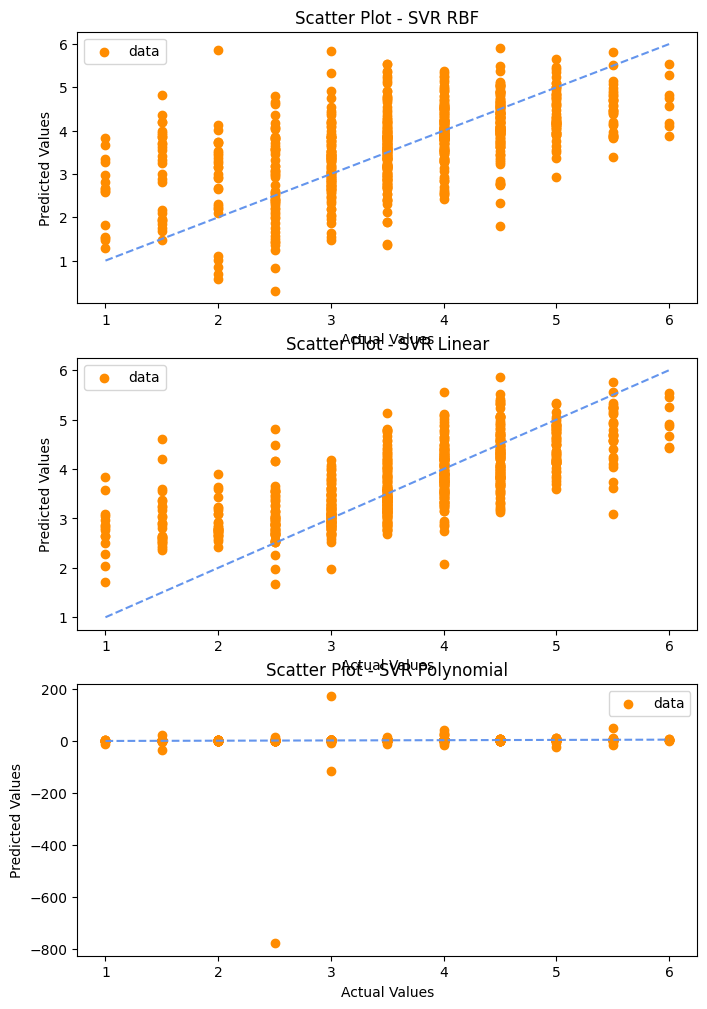

In [202]:
# To evaluate on train data
svregressor(model_train_scaled, process="train")

In [218]:
svregressor(model_test_scaled, process="test")

[6.58876345 1.57196411 3.87581479] [] []
[6.58876345 1.57196411 3.87581479] [6.58876345 1.57196411 3.87581479] []
[6.58876345 1.57196411 3.87581479] [6.58876345 1.57196411 3.87581479] [6.58876345 1.57196411 3.87581479]


In [219]:
X_train,X_test,y_train,y_test=train_test_split(model_train_scaled,score,test_size=0.3, random_state=42)

In [221]:
#PCA 
from sklearn.decomposition import PCA
#from sklearn.model_selection import train_test_split
#X_train,X_test,y_train,y_test=train_test_split(model_train_scaled,train_score.iloc[:,1],test_size=0.3, random_state=42)
pca = PCA(n_components=3)

principalComponents= pca.fit_transform(model_train_scaled)
principalComponents_test=pca.transform(model_test_scaled)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC1', 'PC2','PC3'])


[[0.22402196 0.02306166 0.01663574 0.20155076 0.21976756 0.22086571
  0.21745508 0.22646416 0.12755641 0.222811   0.21769817 0.22681277
  0.21159452 0.11105836 0.23273883 0.13891457 0.05709529 0.04542115
  0.01013678 0.02434782 0.0026222  0.20516232 0.23054739 0.20069868
  0.13705708 0.05693817 0.02679854 0.01620969 0.02099326 0.18149433
  0.18551675 0.02018835 0.23055162 0.20069868 0.13705708 0.05693817
  0.02679854 0.01620969 0.02099326 0.18149433 0.18551675 0.02018835]
 [0.11092068 0.13761304 0.1495485  0.01155624 0.06723846 0.03091552
  0.00678978 0.03730999 0.00808121 0.06375924 0.06895172 0.00644527
  0.0696899  0.07029516 0.03884025 0.04259258 0.41096267 0.05902104
  0.01045363 0.0287597  0.01516727 0.02890339 0.03723101 0.03836179
  0.03890565 0.10989824 0.39481039 0.00248909 0.3911993  0.03409067
  0.02460751 0.21053732 0.03724552 0.03836179 0.03890565 0.10989824
  0.39481039 0.00248909 0.3911993  0.03409067 0.02460751 0.21053732]
 [0.10224154 0.0989564  0.09520334 0.04892585 

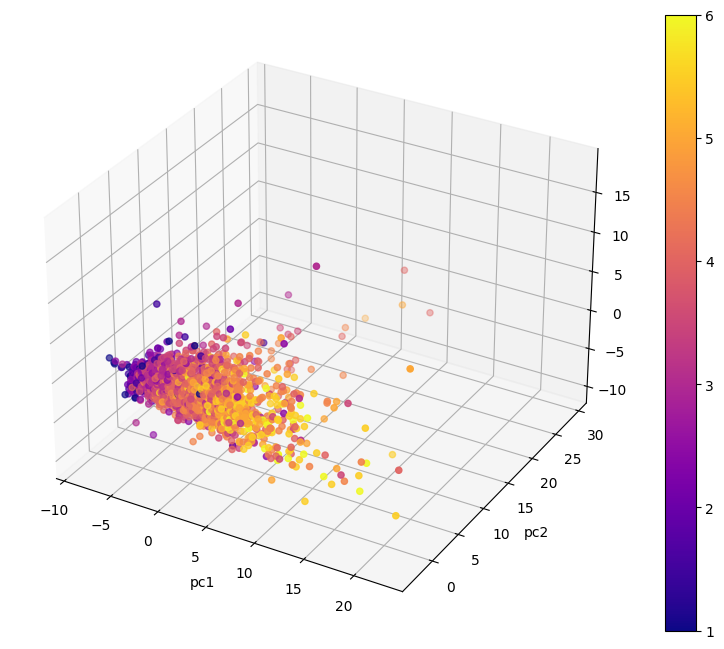

In [222]:
print(abs(pca.components_))
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(principalDf['PC1'],principalDf['PC2'],principalDf['PC3'],c=score,cmap='plasma')
plt.xlabel('pc1')
plt.ylabel('pc2')
plt.colorbar(scatter)

In [223]:
pca.explained_variance_ratio_

array([0.42337252, 0.11035833, 0.07035952])

MAE: SVR_RBF : 0.6656049443027159
RMSE: SVR_RBF :0.9397818629053647
R-squared: SVR_RBF:0.1326708483999539
MAE: SVR_Linear : 0.6152421973735342
RMSE: SVR_Linear :0.6563035639670834
R-squared: SVR_Linear:0.3942943189307132
MAE: SVR_Polynomial : 0.7767566658076384
RMSE: SVR_Polynomial :0.9882206978621592
R-squared: SVR_Polynomial:0.08796641720600806


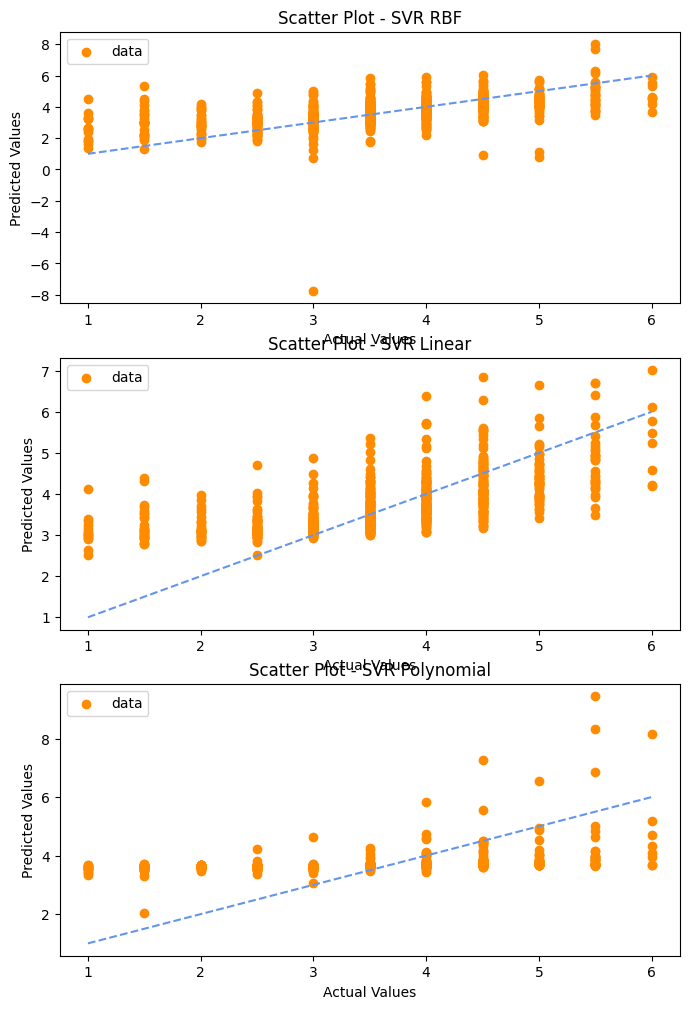

In [224]:
svregressor(principalComponents, process="train")

In [229]:
#UMAP
import umap
reducer = umap.UMAP(random_state=42)
embedding_train = reducer.fit_transform(X_train)


In [230]:
print(embedding_train.shape,y_train.shape)

(1726, 2) (1726,)


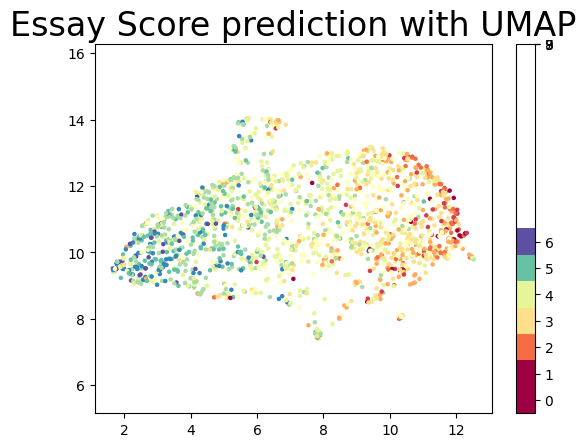

In [231]:
plt.scatter(reducer.embedding_[:, 0], reducer.embedding_[:, 1], s= 5, c=y_train, cmap='Spectral')
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(8)-0.5).set_ticks(np.arange(10))
plt.title('Essay Score prediction with UMAP', fontsize=24);

In [233]:
#Use UMAP in SVR

svr = SVR(kernel="linear", C=1000, gamma=0.1, epsilon=0.1)
svr.fit(embedding_train, y_train)
embedding_test = reducer.transform(X_test)
y_pred_umap = svr.predict(embedding_test)

MAE: SVR_linear : 0.6016516828055977
RMSE: SVR_linear  :0.6190888726522463
R-squared: SVR_linear :0.4286399345668447


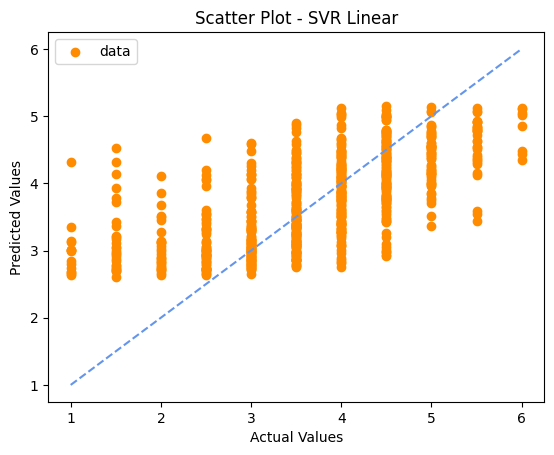

In [235]:
    mae = mean_absolute_error(y_test, y_pred_umap)
    rmse = mean_squared_error(y_test, y_pred_umap)
    r2 = r2_score(y_test, y_pred_umap)
    print(f'MAE: SVR_linear : {mae}')
    print(f'RMSE: SVR_linear  :{rmse}')
    print(f'R-squared: SVR_linear :{r2}')
    plt.scatter(y_test, y_pred_umap, color='darkorange', label='data')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='cornflowerblue')
    plt.title(f'Scatter Plot - SVR Linear')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.legend()

In [236]:
#tsne
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
projections = tsne.fit_transform(X_train)
projections.shape

(1726, 2)

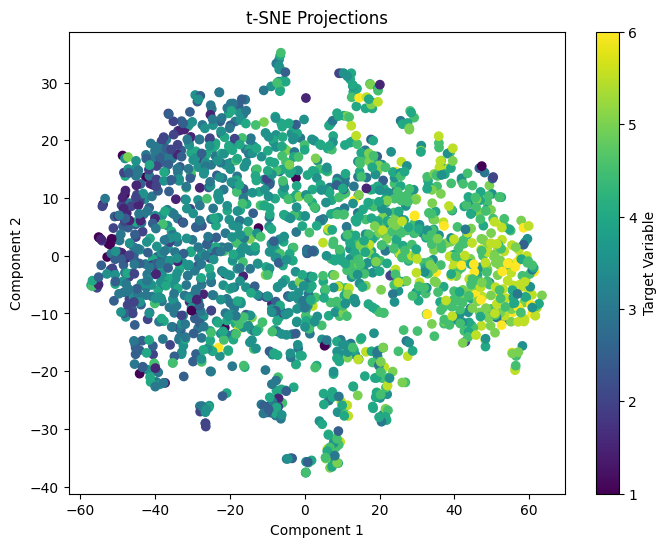

In [237]:
plt.figure(figsize=(8, 6))
plt.scatter(projections[:, 0], projections[:, 1], c=y_train, cmap='viridis')
plt.title('t-SNE Projections')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar(label='Target Variable')
plt.show()

In [238]:
svr = SVR(kernel="linear", C=1000, gamma=0.1, epsilon=0.1)
svr.fit(projections, y_train)
tsne_test = reducer.transform(X_test)
y_pred_tsne = svr.predict(tsne_test)

MAE: SVR_linear : 0.8692387104768908
RMSE: SVR_linear  :1.2373682607034426
R-squared: SVR_linear :-0.14197305367747082


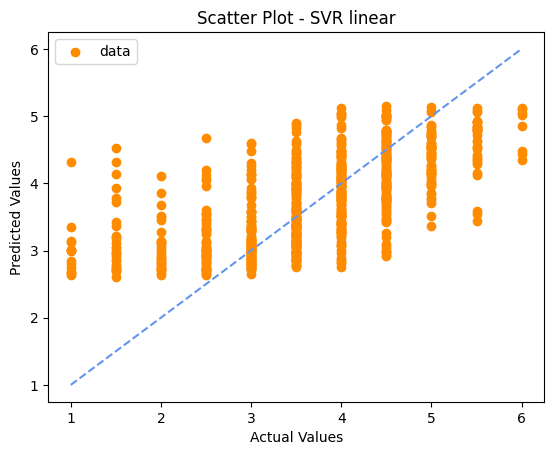

In [239]:
    mae = mean_absolute_error(y_test, y_pred_tsne)
    rmse = mean_squared_error(y_test, y_pred_tsne)
    r2 = r2_score(y_test, y_pred_tsne)
    print(f'MAE: SVR_linear : {mae}')
    print(f'RMSE: SVR_linear  :{rmse}')
    print(f'R-squared: SVR_linear :{r2}')
    plt.scatter(y_test, y_pred_umap, color='darkorange', label='data')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='cornflowerblue')
    plt.title(f'Scatter Plot - SVR linear')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.legend()